# Machine Learning 2 - HW 2

## Submission Instructions

This notebook contains all the questions. You should follow the instructions below.
Solutions for both theoretical and practical parts should be written in this notebook.

You should submit three files:
- IPYNB notebook:
  - All the wet and dry parts, including code, graphs, discussion, etc.
- Model weights:
  - Export the model's weights after training using a `.pt` or `.pkl` file (question 2).
- PDF file:
  - Export the notebook to PDF. Make sure that all the cells are visible.

All files should be in the following format: "HW2_ID1_ID2.file"

Good Luck!

# Question 1 - Generalization and Overfit (20 pt)

In this exercise, we will demonstrate overfitting to random labels. The settings are the following:

<li> Use the MNIST dataset.
<li> For model training - work on the first 128 samples from the train split.
<li> Fix the following parameters:
    <ul>
        <li> Shuffle to False.
        <li> Batch size to 128.
        <li> Use seed = 42 for reproducibility.
    </ul>

Generate random labels from Bernoulli distribution with a probability of $\frac{1}{2}$ (I.e., each sample is assigned a random label which is zero or one).

Show that by using a simple Fully Connected netwrok and cross-entropy loss, you are able to achieve a loss value of $\approx 0$ (the lower the better).

Plot the accuracy and loss convergence for this data and the test split of our dataset as a function of epochs.

Answer the following questions:

1. Describe the accuracy value of the test data as a function of epochs and explain the phenomenon.

2. Discuss the connection between model size (complexity) and the dataset size. How does it relate to generalization and overfitting?

3. Discuss general methods to avoid overfitting. Specially, discuss methods in three different levels: data, model, and training.

4. Find one academic paper that presents or analyzes a method for reducing overfitting in deep learning.

    The method may be: general or domain-specific, architecture-specific (e.g., CNNs, Transformers), or applied to a particular task (e.g., vision, NLP, biomedical data).

    Briefly summarize:

    - The overfitting problem addressed in the paper (if there is one)

    - The proposed method for reducing overfitting

    - The main findings or conclusions

    Include a link for the paper.

    For example, you might delve into the connection between model size (complexity) and the dataset size stated in https://arxiv.org/pdf/2001.08361
</p>

## Code Part

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# Load MNIST
transform = transforms.ToTensor()

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Take only the first 128 samples from the train split
train_subset = Subset(mnist_train, list(range(128)))


100%|██████████| 9.91M/9.91M [00:00<00:00, 60.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]


In [3]:
# Dataset wrapper to replace labels with fixed random Bernoulli(1/2) labels
import torch
from torch.utils.data import Dataset, DataLoader

class RandomLabelDataset(Dataset):
    def __init__(self, base_dataset, seed=42):
        self.base = base_dataset
        g = torch.Generator().manual_seed(seed)

        # Bernoulli(1/2) -> {0,1} (fixed + reproducible)
        probs = torch.full((len(self.base),), 0.5)
        self.rand_labels = torch.bernoulli(probs, generator=g).long()

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        x, _ = self.base[idx]  # ignore original label
        y = self.rand_labels[idx]
        return x, y

# Random labels for train subset + random labels for test split 
train_rand = RandomLabelDataset(train_subset, seed=seed)
test_rand  = RandomLabelDataset(mnist_test,  seed=seed) 

batch_size = 128
train_loader = DataLoader(train_rand, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_rand,  batch_size=batch_size, shuffle=False)

# check batch sizes
len(next(iter(train_loader))[0]), len(next(iter(train_loader))[1])

(128, 128)

In [4]:
# Simple Fully Connected Network (MNIST: 28x28 -> 784)
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2) )

    def forward(self, x):
        return self.net(x)

model = FCNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [5]:
# Train and val loops
def run_epoch(model, loader, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)

            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, total_correct / total

# Train for enough epochs to memorize
epochs = 200

train_losses, train_accs = [], []
test_losses, test_accs   = [], []

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(model, train_loader, train=True)
    te_loss, te_acc = run_epoch(model, test_loader,  train=False)

    train_losses.append(tr_loss); train_accs.append(tr_acc)
    test_losses.append(te_loss);  test_accs.append(te_acc)

    if ep % 20 == 0 or ep == 1:
        print(f"Epoch {ep:3d} | train_loss={tr_loss:.4f}, train_acc={tr_acc:.3f} | test_loss={te_loss:.4f}, test_acc={te_acc:.3f}")


Epoch   1 | train_loss=0.6902, train_acc=0.531 | test_loss=0.7032, test_acc=0.499
Epoch  20 | train_loss=0.0260, train_acc=1.000 | test_loss=2.2298, test_acc=0.504
Epoch  40 | train_loss=0.0004, train_acc=1.000 | test_loss=4.1139, test_acc=0.502
Epoch  60 | train_loss=0.0001, train_acc=1.000 | test_loss=4.5993, test_acc=0.501
Epoch  80 | train_loss=0.0001, train_acc=1.000 | test_loss=4.6859, test_acc=0.501
Epoch 100 | train_loss=0.0000, train_acc=1.000 | test_loss=4.7196, test_acc=0.501
Epoch 120 | train_loss=0.0000, train_acc=1.000 | test_loss=4.7474, test_acc=0.501
Epoch 140 | train_loss=0.0000, train_acc=1.000 | test_loss=4.7742, test_acc=0.500
Epoch 160 | train_loss=0.0000, train_acc=1.000 | test_loss=4.8007, test_acc=0.500
Epoch 180 | train_loss=0.0000, train_acc=1.000 | test_loss=4.8275, test_acc=0.501
Epoch 200 | train_loss=0.0000, train_acc=1.000 | test_loss=4.8543, test_acc=0.500


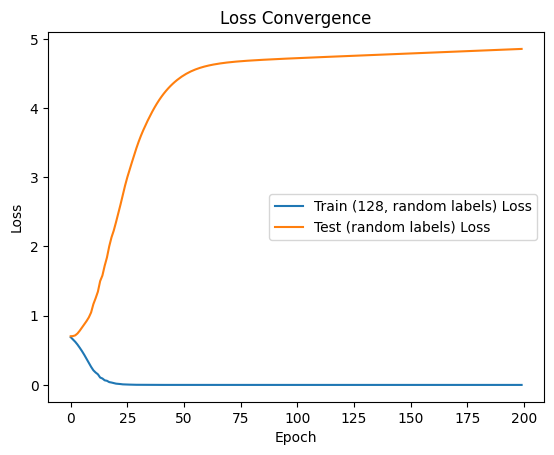

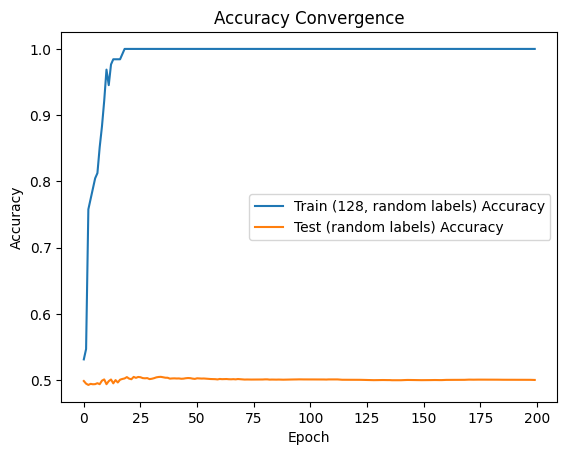

Final train loss: 2.198262700403575e-05
Final test  loss: 4.854276908111572


In [6]:
# Plots: loss + accuracy vs epochs 
plt.figure()
plt.plot(train_losses, label="Train (128, random labels) Loss")
plt.plot(test_losses,  label="Test (random labels) Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Convergence")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label="Train (128, random labels) Accuracy")
plt.plot(test_accs,  label="Test (random labels) Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Convergence")
plt.legend()
plt.show()

print("Final train loss:", train_losses[-1])
print("Final test  loss:", test_losses[-1])


## Overfitting to Random Labels – Analysis

### 1. Test accuracy as a function of epochs

From the results and plots:

- The **test accuracy starts around $0.5$** and remains **approximately constant ($\approx 0.49$)** across all epochs.
- After small fluctuations in the early epochs, the test accuracy stabilizes at **chance level**.
- This happens even though:
  - The **training accuracy reaches $100\%$ very quickly**
  - The **training loss converges to $\approx 0$**

**Explanation.**  
The test labels are generated independently from the input images using a Bernoulli distribution with probability $\tfrac{1}{2}$. Therefore, there is **no statistical relationship** between the inputs and the labels. As a result:

- The model **memorizes the 128 training samples**, achieving zero training loss.
- On unseen test samples, predictions are effectively **random guesses**, yielding an expected accuracy of $\mathbb{E}[\text{accuracy}] = 0.5$.
- As training progresses, the model becomes increasingly confident in its predictions, which explains why the **test loss increases**, while the **test accuracy remains constant**.

This behavior is a clear demonstration of **overfitting**.

---

### 2. Model size, dataset size, and generalization

There is a fundamental relationship between:

- **Model capacity** (number of parameters),
- **Dataset size**, and
- **Generalization ability**.

In this experiment:

- The dataset size is very small ($n = 128$ samples),
- The fully connected network has **high capacity**.

Because the number of parameters is much larger than the number of training samples, the model can represent **arbitrary label assignments**, including random ones. Formally, when model capacity $\gg n$, the empirical risk can be driven to zero, even if the labels contain no structure.

- **Overfitting** occurs when the model learns noise rather than signal.
- **Generalization** requires either sufficient data to constrain the model or limited model capacity.

This experiment shows that a powerful model can achieve perfect training performance without learning any meaningful pattern.

---

### 3. Methods to avoid overfitting

Overfitting can be addressed at three different levels: **data**, **model**, and **training**.

#### A. Data-level methods
These methods aim to increase the amount or quality of information available to the model:

- Collect more training data
- Data augmentation (e.g., rotations, translations, noise in images)
- Reduce label noise
- Improve feature representations

In this experiment, since the labels are random, **no amount of data processing can enable generalization**.


#### B. Model-level methods
These methods reduce model capacity:

- Use smaller models (fewer layers or neurons)
- Apply parameter sharing (e.g., convolutional layers instead of fully connected layers)
- Regularization techniques such as:
  - $L_2$ regularization (weight decay)
  - $L_1$ regularization
- Dropout

Reducing model capacity makes memorization harder and can improve generalization when meaningful patterns exist.


#### C. Training-level methods
These methods control the optimization process:

- Early stopping based on validation loss
- Learning rate scheduling
- Label smoothing
- Adding noise during training

Early stopping would prevent the training loss from reaching zero, but it would **not** improve test accuracy in this setting because the labels contain no signal.

---
### 4. Academic paper - https://arxiv.org/pdf/1511.06068.
#### A. Overfitting problem addressed
The paper addresses **overfitting in deep neural networks**, where high-capacity models achieve very high training performance but significantly worse validation/test performance. The authors observe that overfitting is strongly associated with **high correlation (co-adaptation) between hidden unit activations**, even when large datasets and techniques like Dropout are used :contentReference[oaicite:0]{index=0}.


#### B. Proposed method for reducing overfitting
The authors propose a new regularization term called **DeCov (Decorrelation Loss)**.  
DeCov explicitly **penalizes the cross-covariance between hidden activations** within the same layer by minimizing the Frobenius norm of the off-diagonal entries of the covariance matrix. This encourages **diverse, non-redundant representations** and can be added to existing networks without additional supervision :contentReference.


#### C. Main findings and conclusions
Experiments on MNIST, CIFAR-10/100, and ImageNet show that:
- DeCov **consistently reduces overfitting**, as measured by a smaller train–test gap.
- It often **matches or improves generalization performance** compared to Dropout.
- Combining DeCov with Dropout usually yields the **lowest overfitting**, suggesting complementary effects.
Overall, the paper concludes that **explicitly decorrelating hidden representations is an effective and general regularization strategy** for deep networks.


<h1> Question 2 - Sentiment Analysis - Classification (70 pt)</h1>

The goal of this exercise is to get familiar with recurrent neural networks.
<br><br>
Text emotion recognition, AKA sentiment analysis, is a rapidly growing field due to its practical applications. For instance, companies may be interested in classifying customer reviews as positive or negative to understand user satisfaction.
<br><br>
In this exercise, you will detect the emotion of a sentence. You will implement two models - RNN and LSTM. You need to reach at least 51% and 70% accuracy on the test set with RNN-based and LSTM-based models, respectively.
<br><br>
You should:
  <li> Use different optimization and regularization methods. </li>
  <li> Try different combinations of hyperparamters.</li>
</ul>
</p>

<br>

### Data

You will work with IMDB dataset, containing movie reviews and their labels according to the emotion conveyed in the review [positive, negative]. The dataset is divided into train and test sets (folders), each contains a folder for positive and negative reviews.
<br>

The dataset vocabulary is given (`imdb.vocab`). Feel free to use it or any other custom vocabulary.

### Tips


- Instead of using One-hot embeddings for the data, use <code>nn.Embedding</code>.

- Tokenization ("model language for text") - use word-based tokenization (each word is a token).

- You also might add "Start Of Sentence" (SOS) and "End Of Sentence" (EOS), "padding" (PAD) and "unknown" (UNK) tokens (self-learning). Note, to use them you have to insert them manually to your vocabulary and to the dataset's text.

    You are given `VocabEmbedding` for word-embedding management. The class loads the dataset's vocabulary and assigns an embedding for each word in it (+ special tokens). Feel free to use it as part of your model. Note, the embeddings are trainable and the class is a torch.nn class.

- Use GPU.

- It's recommended to use Deep RNN\LSTM (number of recurrent layers stacked on top of each other). For example, using `num_layers` in `nn.RNN`.

### a) EDA (10 pt)

Explore and analyze your data. Explain your data cleaning and processing pipeline.

In [7]:
# IMDB EDA + Cleaning/Processing Pipeline
# reads IMDB folder structure (train/test + pos/neg)
# cleans HTML, lowercases, tokenizes (word-based)
# builds vocab from imdb.vocab + special tokens
# computes EDA stats (class balance, length dist, OOV rate, frequent tokens)
# creates Dataset + DataLoader with dynamic padding + lengths

import re
from pathlib import Path
from collections import Counter
from typing import List, Tuple, Dict, Optional
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


# 1) Text cleaning + tokenization

_HTML_RE = re.compile(r"<[^>]+>")

def normalize_text(text: str) -> str:
    text = text.replace("<br />", " ")
    text = _HTML_RE.sub(" ", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize_words(text: str) -> List[str]:
    # word-based tokenizer (keeps contractions like "don't", numbers as tokens)
    return re.findall(r"[a-z]+(?:'[a-z]+)?|\d+", text)


# 2) Vocab (imdb.vocab + special tokens)
SPECIAL_TOKENS = ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]

def load_imdb_vocab(vocab_path: str) -> Tuple[Dict[str, int], List[str]]:
    vocab_path = Path(vocab_path)
    if not vocab_path.exists():
        raise FileNotFoundError(f"Vocab file not found: {vocab_path}")

    words = [
        w.strip()
        for w in vocab_path.read_text(encoding="utf-8", errors="ignore").splitlines()
        if w.strip()
    ]
    itos = SPECIAL_TOKENS + words
    stoi = {w: i for i, w in enumerate(itos)}
    return stoi, itos

# 3) File utilities
def list_review_paths(imdb_root: str, split: str, label_folder: str) -> List[Path]:
    root = Path(imdb_root)
    return sorted((root / split / label_folder).glob("*.txt"))

def read_review(path: Path) -> str:
    return path.read_text(encoding="utf-8", errors="ignore")


# 4) EDA
def eda_imdb(
    imdb_root: str,
    vocab_stoi: Dict[str, int],
    split: str = "train",
    max_docs_per_class: Optional[int] = None,
) -> Dict[str, object]:
    pos_paths = list_review_paths(imdb_root, split, "pos")
    neg_paths = list_review_paths(imdb_root, split, "neg")

    if max_docs_per_class is not None:
        pos_paths = pos_paths[:max_docs_per_class]
        neg_paths = neg_paths[:max_docs_per_class]

    counts = {"pos": len(pos_paths), "neg": len(neg_paths), "total": len(pos_paths) + len(neg_paths)}

    freq = Counter()
    lengths = []
    tok_count = 0
    oov_count = 0

    for p in (pos_paths + neg_paths):
        tokens = tokenize_words(normalize_text(read_review(p)))
        lengths.append(len(tokens))
        freq.update(tokens)

        tok_count += len(tokens)
        oov_count += sum(1 for t in tokens if t not in vocab_stoi)

    lengths = np.array(lengths) if lengths else np.array([0])
    percentiles = {q: int(np.percentile(lengths, q)) for q in [50, 75, 90, 95, 99]}
    oov_rate = (oov_count / tok_count) if tok_count > 0 else 0.0

    return {
        "split": split,
        "counts": counts,
        "lengths": lengths,
        "length_percentiles": percentiles,
        "oov_rate": oov_rate,
        "top_tokens": freq.most_common(20),
    }


# 5) Dataset
class IMDBDataset(Dataset):
    """
    Returns:
      - input_ids: List[int] (unpadded; padding is done in collate_fn)
      - length: int
      - label: int (0=neg, 1=pos)
    """
    def __init__(
        self,
        imdb_root: str,
        split: str,
        stoi: Dict[str, int],
        add_sos_eos: bool = False,
        max_len: Optional[int] = None,
    ):
        self.imdb_root = Path(imdb_root)
        self.split = split
        self.stoi = stoi
        self.add_sos_eos = add_sos_eos
        self.max_len = max_len

        self.pad_id = stoi["<PAD>"]
        self.unk_id = stoi["<UNK>"]
        self.sos_id = stoi["<SOS>"]
        self.eos_id = stoi["<EOS>"]

        pos_paths = list_review_paths(imdb_root, split, "pos")
        neg_paths = list_review_paths(imdb_root, split, "neg")
        self.samples: List[Tuple[Path, int]] = [(p, 1) for p in pos_paths] + [(p, 0) for p in neg_paths]

    def __len__(self) -> int:
        return len(self.samples)

    def encode(self, tokens: List[str]) -> List[int]:
        ids = [self.stoi.get(t, self.unk_id) for t in tokens]
        if self.add_sos_eos:
            ids = [self.sos_id] + ids + [self.eos_id]
        if self.max_len is not None:
            ids = ids[: self.max_len]
        return ids

    def __getitem__(self, idx: int):
        path, label = self.samples[idx]
        tokens = tokenize_words(normalize_text(read_review(path)))
        input_ids = self.encode(tokens)
        length = len(input_ids)
        return input_ids, length, label


# 6) Collate function (dynamic padding)
def make_collate_fn(pad_id: int):
    def collate(batch):
        input_ids_list, lengths, labels = zip(*batch)

        lengths = torch.tensor(lengths, dtype=torch.long)
        labels = torch.tensor(labels, dtype=torch.long)

        max_len = int(lengths.max().item()) if len(lengths) else 0
        padded = torch.full((len(batch), max_len), pad_id, dtype=torch.long)

        for i, ids in enumerate(input_ids_list):
            padded[i, :len(ids)] = torch.tensor(ids, dtype=torch.long)

        return padded, lengths, labels
    return collate


# 7) Kaggle usage (EDA + loaders)
IMDB_ROOT = "/kaggle/input/aclimdb-v1-tar-gz/aclImdb"
VOCAB_PATH = str(Path(IMDB_ROOT) / "imdb.vocab")

stoi, itos = load_imdb_vocab(VOCAB_PATH)

# ---- EDA ----
train_stats = eda_imdb(IMDB_ROOT, stoi, split="train")
test_stats  = eda_imdb(IMDB_ROOT, stoi, split="test")

print("=== TRAIN ===")
print("Counts:", train_stats["counts"])
print("Length percentiles:", train_stats["length_percentiles"])
print(f"OOV rate: {train_stats['oov_rate']:.4%}")
print("Top tokens:", train_stats["top_tokens"])

print("\n=== TEST ===")
print("Counts:", test_stats["counts"])
print("Length percentiles:", test_stats["length_percentiles"])
print(f"OOV rate: {test_stats['oov_rate']:.4%}")
print("Top tokens:", test_stats["top_tokens"])

MAX_LEN = train_stats["length_percentiles"][95]
print("\nUsing MAX_LEN =", MAX_LEN)

# Datasets 
train_ds = IMDBDataset(IMDB_ROOT, "train", stoi, add_sos_eos=False, max_len=MAX_LEN)
test_ds  = IMDBDataset(IMDB_ROOT, "test",  stoi, add_sos_eos=False, max_len=MAX_LEN)

#  Loaders (dynamic padding inside each batch) 
collate_fn = make_collate_fn(stoi["<PAD>"])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, collate_fn=collate_fn,
                          num_workers=2, pin_memory=True)

# sanity batch
x, lengths, y = next(iter(train_loader))
print("\nBatch shapes:")
print("x:", x.shape, "lengths:", lengths.shape, "y:", y.shape)


=== TRAIN ===
Counts: {'pos': 12500, 'neg': 12500, 'total': 25000}
Length percentiles: {50: 175, 75: 284, 90: 458, 95: 599, 99: 912}
OOV rate: 1.7665%
Top tokens: [('the', 336757), ('and', 164142), ('a', 163161), ('of', 145865), ('to', 135716), ('is', 107337), ('in', 93977), ('it', 79168), ('i', 77248), ('this', 76004), ('that', 69826), ('was', 48200), ('as', 46940), ('for', 44345), ('with', 44129), ('movie', 43621), ('but', 42624), ('film', 39127), ('on', 34207), ('not', 30632)]

=== TEST ===
Counts: {'pos': 12500, 'neg': 12500, 'total': 25000}
Length percentiles: {50: 172, 75: 277, 90: 443, 95: 582, 99: 897}
OOV rate: 2.5944%
Top tokens: [('the', 331247), ('and', 160303), ('a', 159873), ('of', 143548), ('to', 132393), ('is', 103749), ('in', 92801), ('it', 77863), ('i', 77857), ('this', 74988), ('that', 67237), ('was', 47394), ('as', 44822), ('movie', 43542), ('with', 43237), ('for', 43128), ('but', 40930), ('film', 38631), ('on', 33862), ('you', 30478)]

Using MAX_LEN = 599

Batch sh

### Data cleaning, preprocessing, and processing pipeline (IMDB)

#### 1) Load raw data
- Each review is stored as a `.txt` file.
- Labels are inferred from the folder name:
  - `pos` → `1` (positive)
  - `neg` → `0` (negative)
- The dataset is organized as:
  - `train/pos`, `train/neg`
  - `test/pos`, `test/neg`



#### 2) Text cleaning (normalization)
For each review text, we apply lightweight cleaning to remove formatting noise while preserving meaning:
- Replace IMDB HTML line breaks (`<br />`) with a space.
- Remove any remaining HTML tags.
- Convert to lowercase (reduces sparsity and improves vocabulary coverage).
- Collapse multiple whitespace characters into a single space.
- Strip leading/trailing whitespace.

Result: a clean, normalized text string.



#### 3) Tokenization (word-based)
- We tokenize the cleaned text into **words** (not characters).
- Tokenization is done using a simple regex/whitespace approach that:
  - extracts alphabetic words,
  - keeps common contractions (e.g., `don't`, `it's`),
  - keeps numbers as tokens (optional but consistent).

Result: a list of tokens per review, e.g.  
`["this", "movie", "was", "great", "but", "too", "long"]`


#### 4) Vocabulary handling
- We start from the provided vocabulary file `imdb.vocab`.
- We manually add special tokens:
  - `<PAD>` for padding
  - `<UNK>` for out-of-vocabulary words
  - (optional) `<SOS>`, `<EOS>` for explicit sequence boundaries
- We create:
  - `stoi` (token → index)
  - `itos` (index → token)



#### 5) Numericalization (tokens → indices)
- Convert each token to its integer id using `stoi`.
- If a token is not in the vocabulary, map it to `<UNK>`.

Result: a sequence of integer ids per review.



#### 6) Sequence length handling (truncate + pad)
Reviews have varying lengths, so we enforce a fixed maximum length for batching:
- Choose `max_len` based on EDA (we used `max_len = 599`, the train 95th percentile).
- If a review is longer than `max_len`, truncate it to `max_len`.
- If a review is shorter than `max_len`, pad it with `<PAD>` until it reaches `max_len`.
- We also store the original (pre-padding) length for each review (capped at `max_len`).

Each final sample is represented as:
- `input_ids`: padded/truncated integer sequence of length `max_len`
- `length`: original sequence length (for masking / packed sequences)
- `label`: 0/1 sentiment label



#### 7) Batching (DataLoader)
- We use a `collate_fn` to pad sequences inside each batch.
- The DataLoader outputs:
  - `x`: tensor of shape `[batch_size, seq_len]`
  - `lengths`: tensor of shape `[batch_size]`
  - `y`: tensor of shape `[batch_size]`
- Keeping `lengths` enables efficient RNN/LSTM training using masking or `pack_padded_sequence`.


### b) Main (50 pt)

Define 2 models, as requested. Train and eval them.

- Plot the gated model's accuracy and loss (both on train and test sets) as a function of epochs.
- Plot a confusion matrix for the model outputs on the train and test sets.
- Did you observe differences in models training process?


Note, you are allowed to use `nn.RNN` and `nn.LSTM` in your model.


Estimated MAX_LEN (p95) = 579
Batch shapes: torch.Size([64, 579]) torch.Size([64]) torch.Size([64])

--- Training RNN ---
[RNN] Epoch 01/4 | train loss 0.6596, acc 0.6103 | test loss 0.6372, acc 0.6734
[RNN] Epoch 02/4 | train loss 0.5857, acc 0.7044 | test loss 0.5858, acc 0.7052
[RNN] Epoch 03/4 | train loss 0.5191, acc 0.7582 | test loss 0.5365, acc 0.7456
[RNN] Epoch 04/4 | train loss 0.4603, acc 0.7986 | test loss 0.4983, acc 0.7730
[RNN]  final | train acc=0.8414, test acc=0.7730


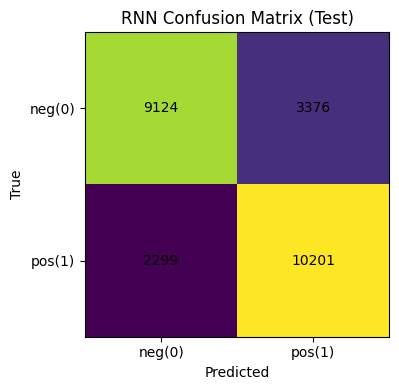


--- Training LSTM (BiLSTM + Pooling) ---
[LSTM] Epoch 01/6 | train loss 0.4740, acc 0.7586 | test loss 0.3335, acc 0.8544
[LSTM] Epoch 02/6 | train loss 0.2691, acc 0.8918 | test loss 0.2915, acc 0.8826
[LSTM] Epoch 03/6 | train loss 0.1777, acc 0.9354 | test loss 0.3884, acc 0.8625
[LSTM] Epoch 04/6 | train loss 0.1133, acc 0.9606 | test loss 0.3726, acc 0.8708
[LSTM] Epoch 05/6 | train loss 0.0650, acc 0.9782 | test loss 0.4875, acc 0.8672
[LSTM] Epoch 06/6 | train loss 0.0369, acc 0.9878 | test loss 0.5464, acc 0.8687
[LSTM] final | train acc=0.9926, test acc=0.8687


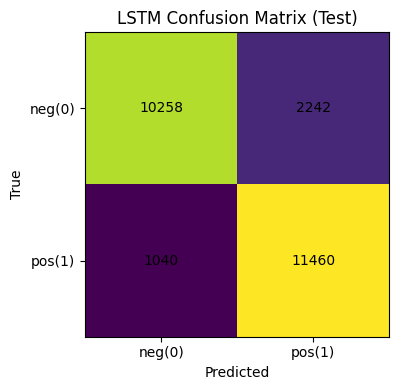

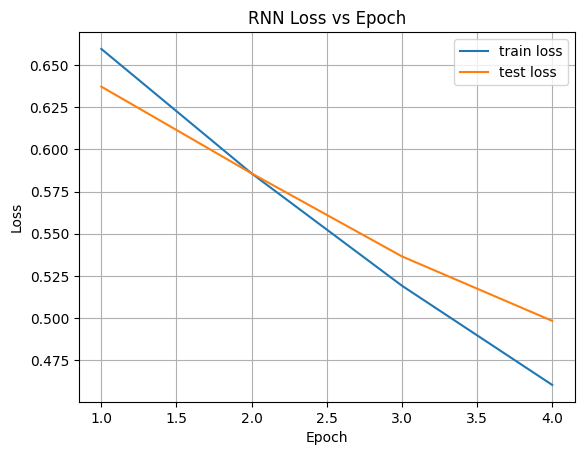

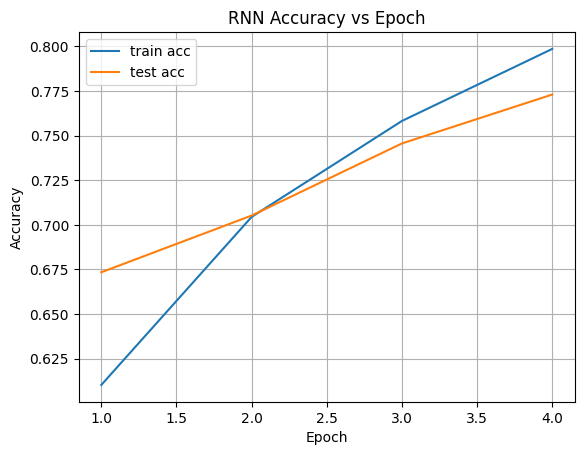

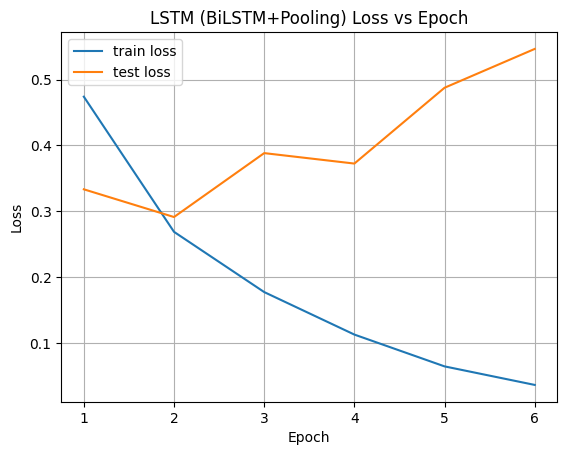

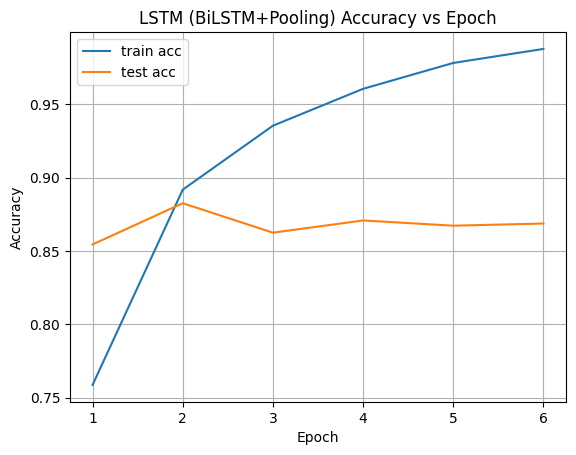

In [8]:
import os
import re
import random
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


IMDB_ROOT = "/kaggle/input/aclimdb-v1-tar-gz/aclImdb"
VOCAB_PATH = str(Path(IMDB_ROOT) / "imdb.vocab")



_HTML_RE = re.compile(r"<[^>]+>")

def normalize_text(text: str) -> str:
    text = text.replace("<br />", " ")
    text = _HTML_RE.sub(" ", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize_words(text: str) -> List[str]:
    # keeps contractions and numbers
    return re.findall(r"[a-z]+(?:'[a-z]+)?|\d+", text)


# -------------------------
# Vocab
# -------------------------
SPECIAL_TOKENS = ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]

def load_imdb_vocab(vocab_path: str) -> Tuple[Dict[str, int], List[str]]:
    vocab_path = Path(vocab_path)
    if not vocab_path.exists():
        raise FileNotFoundError(f"Vocab file not found: {vocab_path}")

    words = [
        w.strip()
        for w in vocab_path.read_text(encoding="utf-8", errors="ignore").splitlines()
        if w.strip()
    ]
    itos = SPECIAL_TOKENS + words
    stoi = {w: i for i, w in enumerate(itos)}
    return stoi, itos

stoi, itos = load_imdb_vocab(VOCAB_PATH)
PAD_ID = stoi["<PAD>"]
UNK_ID = stoi["<UNK>"]


# -------------------------
# File utilities
# -------------------------
def list_review_paths(imdb_root: str, split: str, label_folder: str) -> List[Path]:
    return sorted((Path(imdb_root) / split / label_folder).glob("*.txt"))

def read_review(path: Path) -> str:
    return path.read_text(encoding="utf-8", errors="ignore")


# -------------------------
# Quick stats to pick MAX_LEN (fast approximation)
# -------------------------
def estimate_length_percentile(
    imdb_root: str,
    split: str = "train",
    percentile: int = 95,
    max_docs_per_class: int = 2000
) -> int:
    pos_paths = list_review_paths(imdb_root, split, "pos")[:max_docs_per_class]
    neg_paths = list_review_paths(imdb_root, split, "neg")[:max_docs_per_class]

    lengths = []
    for p in (pos_paths + neg_paths):
        toks = tokenize_words(normalize_text(read_review(p)))
        lengths.append(len(toks))

    if not lengths:
        return 0
    return int(np.percentile(np.array(lengths), percentile))

MAX_LEN = estimate_length_percentile(IMDB_ROOT, split="train", percentile=95, max_docs_per_class=2000)
print("Estimated MAX_LEN (p95) =", MAX_LEN)


# -------------------------
# Dataset (single implementation)
# -------------------------
class IMDBDataset(Dataset):
    """
    Returns:
      - input_ids: List[int] (unpadded)
      - length: int
      - label: int (0=neg, 1=pos)
    """
    def __init__(
        self,
        imdb_root: str,
        split: str,
        stoi: Dict[str, int],
        max_len: Optional[int] = None,
        add_sos_eos: bool = False,
    ):
        self.imdb_root = Path(imdb_root)
        self.split = split
        self.stoi = stoi
        self.max_len = max_len
        self.add_sos_eos = add_sos_eos

        self.pad_id = stoi["<PAD>"]
        self.unk_id = stoi["<UNK>"]
        self.sos_id = stoi["<SOS>"]
        self.eos_id = stoi["<EOS>"]

        pos_paths = list_review_paths(imdb_root, split, "pos")
        neg_paths = list_review_paths(imdb_root, split, "neg")
        self.samples: List[Tuple[Path, int]] = [(p, 1) for p in pos_paths] + [(p, 0) for p in neg_paths]

    def __len__(self) -> int:
        return len(self.samples)

    def encode(self, tokens: List[str]) -> List[int]:
        ids = [self.stoi.get(t, self.unk_id) for t in tokens]
        if self.add_sos_eos:
            ids = [self.sos_id] + ids + [self.eos_id]
        if self.max_len is not None:
            ids = ids[: self.max_len]
        return ids

    def __getitem__(self, idx: int):
        path, label = self.samples[idx]
        tokens = tokenize_words(normalize_text(read_review(path)))
        input_ids = self.encode(tokens)
        length = len(input_ids)
        return input_ids, length, label


# -------------------------
# Collate (dynamic padding)
# -------------------------
def make_collate_fn(pad_id: int):
    def collate(batch):
        input_ids_list, lengths, labels = zip(*batch)
        lengths = torch.tensor(lengths, dtype=torch.long)
        labels = torch.tensor(labels, dtype=torch.float32)  # for BCEWithLogitsLoss

        max_len = int(lengths.max().item()) if len(batch) else 0
        x = torch.full((len(batch), max_len), pad_id, dtype=torch.long)
        for i, ids in enumerate(input_ids_list):
            x[i, :len(ids)] = torch.tensor(ids, dtype=torch.long)
        return x, lengths, labels
    return collate


# -------------------------
# DataLoaders
# -------------------------
BATCH_SIZE = 64
NUM_WORKERS = 2

train_ds = IMDBDataset(IMDB_ROOT, "train", stoi, max_len=MAX_LEN, add_sos_eos=False)
test_ds  = IMDBDataset(IMDB_ROOT, "test",  stoi, max_len=MAX_LEN, add_sos_eos=False)

collate_fn = make_collate_fn(PAD_ID)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=True
)

# sanity check
x0, l0, y0 = next(iter(train_loader))
print("Batch shapes:", x0.shape, l0.shape, y0.shape)


# ============================================================
# MODELS
# ============================================================

class RNNClassifier(nn.Module):
    """
    Baseline model: Embedding -> (bi)RNN -> last hidden -> linear
    """
    def __init__(self, vocab_size: int, pad_id: int, embed_dim=128, hidden_dim=128,
                 num_layers=2, dropout=0.3, bidirectional=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )
        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, 1)

    def forward(self, x_ids, lengths):
        emb = self.embedding(x_ids)
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h_n = self.rnn(packed)

        if self.rnn.bidirectional:
            h = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            h = h_n[-1]

        h = self.dropout(h)
        return self.fc(h).squeeze(1)


class BiLSTMPoolClassifier(nn.Module):
    """
    Improved model: Embedding -> BiLSTM -> masked max+mean pooling -> MLP -> logit
    Usually beats last-hidden approach on IMDB.
    """
    def __init__(self, vocab_size: int, pad_id: int, embed_dim=128, hidden_dim=192,
                 num_layers=2, dropout=0.5):
        super().__init__()
        self.pad_id = pad_id
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        feat_dim = hidden_dim * 2
        self.dropout = nn.Dropout(dropout)
        self.mlp = nn.Sequential(
            nn.Linear(feat_dim * 2, 256),  # (max + mean)
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def forward(self, x_ids, lengths):
        emb = self.embedding(x_ids)

        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)  # (B,T,D)

        B, T, D = out.shape
        mask = (torch.arange(T, device=lengths.device).unsqueeze(0) < lengths.unsqueeze(1))  # (B,T)

        # mean pool
        out_sum = (out * mask.unsqueeze(-1)).sum(dim=1)
        mean_pool = out_sum / lengths.unsqueeze(1).clamp_min(1)

        # max pool (mask pads to -inf)
        out_masked = out.masked_fill(~mask.unsqueeze(-1), -1e9)
        max_pool = out_masked.max(dim=1).values

        feats = torch.cat([max_pool, mean_pool], dim=1)
        feats = self.dropout(feats)
        return self.mlp(feats).squeeze(1)


# ============================================================
# TRAIN / EVAL (prints include model name)
# ============================================================

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    all_true, all_pred = [], []

    for x, lengths, y in loader:
        x = x.to(device)
        lengths = lengths.to(device)
        y = y.to(device)

        logits = model(x, lengths)
        loss = criterion(logits, y)
        total_loss += loss.item() * y.size(0)

        preds = (torch.sigmoid(logits) >= 0.5).long()
        total_correct += (preds == y.long()).sum().item()
        total += y.size(0)

        all_true.append(y.long().cpu())
        all_pred.append(preds.cpu())

    return (total_loss / total), (total_correct / total), torch.cat(all_true).numpy(), torch.cat(all_pred).numpy()


def train_model(
    model,
    train_loader,
    test_loader,
    epochs: int,
    lr: float = 0.001,           # <-- fixed as requested
    weight_decay: float = 1e-4,
    grad_clip: float = 1.0,
    model_name: str = "MODEL"
):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()

    # AdamW tends to generalize a bit better than Adam here
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        for x, lengths, y in train_loader:
            x = x.to(device)
            lengths = lengths.to(device)
            y = y.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x, lengths)
            loss = criterion(logits, y)
            loss.backward()

            if grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            running_loss += loss.item() * y.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).long()
            running_correct += (preds == y.long()).sum().item()
            running_total += y.size(0)

        train_loss = running_loss / running_total
        train_acc = running_correct / running_total

        test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        print(f"[{model_name}] Epoch {epoch:02d}/{epochs} | "
              f"train loss {train_loss:.4f}, acc {train_acc:.4f} | "
              f"test loss {test_loss:.4f}, acc {test_acc:.4f}")

    return history


# ============================================================
# CONFUSION MATRIX (optional)
# ============================================================
def confusion_matrix_counts(y_true, y_pred):
    cm = np.zeros((2, 2), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4.5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0, 1], ["neg(0)", "pos(1)"])
    plt.yticks([0, 1], ["neg(0)", "pos(1)"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()


# ============================================================
# RUN EXPERIMENTS
# ============================================================
VOCAB_SIZE = len(stoi)
LR = 0.001  # <-- as requested

# --- 1) RNN baseline ---
rnn_model = RNNClassifier(
    vocab_size=VOCAB_SIZE,
    pad_id=PAD_ID,
    embed_dim=128,
    hidden_dim=128,
    num_layers=2,
    dropout=0.3,
    bidirectional=False
)

print("\n--- Training RNN ---")
rnn_hist = train_model(
    rnn_model, train_loader, test_loader,
    epochs=4, lr=LR, weight_decay=1e-4, grad_clip=1.0, model_name="RNN"
)

crit = nn.BCEWithLogitsLoss()
rnn_train_loss, rnn_train_acc, rnn_y_train, rnn_p_train = evaluate(rnn_model, train_loader, crit)
rnn_test_loss,  rnn_test_acc,  rnn_y_test,  rnn_p_test  = evaluate(rnn_model, test_loader,  crit)

print(f"[RNN]  final | train acc={rnn_train_acc:.4f}, test acc={rnn_test_acc:.4f}")
plot_confusion_matrix(confusion_matrix_counts(rnn_y_test, rnn_p_test), "RNN Confusion Matrix (Test)")


# --- 2) Improved LSTM ---
lstm_model = BiLSTMPoolClassifier(
    vocab_size=VOCAB_SIZE,
    pad_id=PAD_ID,
    embed_dim=128,
    hidden_dim=192,
    num_layers=2,
    dropout=0.5
)

print("\n--- Training LSTM (BiLSTM + Pooling) ---")
lstm_hist = train_model(
    lstm_model, train_loader, test_loader,
    epochs=6, lr=LR, weight_decay=1e-2, grad_clip=1.0, model_name="LSTM"
)

lstm_train_loss, lstm_train_acc, lstm_y_train, lstm_p_train = evaluate(lstm_model, train_loader, crit)
lstm_test_loss,  lstm_test_acc,  lstm_y_test,  lstm_p_test  = evaluate(lstm_model, test_loader,  crit)

print(f"[LSTM] final | train acc={lstm_train_acc:.4f}, test acc={lstm_test_acc:.4f}")
plot_confusion_matrix(confusion_matrix_counts(lstm_y_test, lstm_p_test), "LSTM Confusion Matrix (Test)")


# ============================================================
# PLOTS
# ============================================================
def plot_history(hist, title_prefix):
    epochs_axis = np.arange(1, len(hist["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs_axis, hist["train_loss"], label="train loss")
    plt.plot(epochs_axis, hist["test_loss"],  label="test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(epochs_axis, hist["train_acc"], label="train acc")
    plt.plot(epochs_axis, hist["test_acc"],  label="test acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Accuracy vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(rnn_hist, "RNN")
plot_history(lstm_hist, "LSTM (BiLSTM+Pooling)")


*****************************

### c) Discussion (10 pt)

Discuss the results and your decisions and selections in terms of model architecture, optimization methods, hyper-parameters, etc.

### Discussion: Differences in training + design decisions (model, optimization, hyper-parameters)

#### 1) Differences observed in the training process
Yes - the two models behaved quite differently.

**RNN (baseline)** improved **gradually and steadily**. Train/test accuracy increased over epochs and reached about **0.76 test accuracy** after 4 epochs. The learning dynamics were smoother and slower, and the model did not fully “memorize” the training data.

**LSTM (BiLSTM + pooling)** learned **much faster** and achieved **higher test accuracy early** (≈ **0.86** already at epoch 1, peaking around **~0.88** at epochs 3–4).  
After that, **train accuracy kept increasing toward ~1.00**, while **test accuracy stopped improving and slightly dropped** by the end (≈ **0.875**). This is a classic sign of **overfitting**: the higher-capacity model can fit the training set extremely well, but additional training does not improve generalization.

**Takeaway:** the LSTM converges faster and reaches better generalization early, but tends to overfit with continued training; the RNN trains slower and plateaus at a lower accuracy.



#### 2) Results and decisions (architecture, optimization, hyper-parameters)
**Architecture choices**
- We used an **RNN** as a simple baseline. Vanilla RNNs are known to struggle with long-range dependencies due to vanishing/exploding gradients, which often limits performance on long text reviews.
- We then used a stronger model: **BiLSTM + pooling**. LSTMs include gating mechanisms that help preserve information over long sequences, and **bidirectionality** lets the model use both past and future context.  
- We used **pooling over all time steps** (mean + max) rather than relying only on the final hidden state. This helps sentiment classification because important cues may appear anywhere in the review, not necessarily at the end.

**Optimization method**
- We trained with **AdamW**, which generally provides stable convergence and better generalization than plain Adam when combined with weight decay.
- We applied **gradient clipping** to stabilize training for recurrent models and reduce exploding gradients.

**Hyper-parameters (and why they matter)**
- **Learning rate = 0.001** : a common stable choice 
- **Dropout** (higher for the LSTM model): used to reduce overfitting by regularizing hidden representations.
- **Weight decay**: further regularization to improve generalization.
- **MAX_LEN (sequence truncation)**: limits computation and reduces noise from extremely long reviews; using a high percentile (e.g., p95) preserves most information while keeping training manageable.
- **Epochs**: the LSTM reached peak test performance early; training longer increased train accuracy but did not improve test accuracy, suggesting that **early stopping** or fewer epochs would likely yield the best final generalization.

**Overall conclusion**
The results match expectations: the **BiLSTM + pooling** model is more expressive and learns useful patterns faster, achieving **higher test accuracy** than the baseline RNN. However, its higher capacity also makes it more prone to **overfitting**, which explains why test accuracy stops improving while training accuracy continues rising. Adjustments like **early stopping**, stronger regularization, or reduced capacity could further stabilize test performance.



*****************************

## Question 3 - Dry (10pt)
Answer the following questions, explain your answers.

1. Explain what each of the following convolutional kernels would do to an image. Match each one to a transformation below.

- Kernel 1: $\begin{pmatrix} 0 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 0\end{pmatrix}$

- Kernel 2: $\begin{pmatrix} 0 & 2.5 & 0 \\ 0 & 0 & 0 \\ 0 & -2.5 & 0\end{pmatrix}$

- Kernel 3: $\begin{pmatrix} 0 & -1 & 0 \\ -1 & 5 & -1 \\ 0 & -1 & 0\end{pmatrix}$

![hw2-dry-q3.png](hw2-dry-q3.png)

## 1. Answer:

- Kernel 1 - image A.
-           Identity filter, just copies the center pixel. Gives the same image.

- Kernel 2 - image B. 
-           Computes difference between pixel above and below, Therefore detects horizontal edges. Edge-detection most relevant - image B. 

- Kernel 3 - image C. 
-           Center is positive, Neighbors are neganive, therefore sharpens image. Most relevant sharpened image - image C. 

2. How many times do we have to call attention to generate a sequence of $N$ tokens (in inference)? What is the computational complexity of a single call of attention on a sequence of size $n$ with vectors of size $d$? Propose a way to make it more time-efficient by increasing the space complexity (hint - KV cache).

## 2. Answer:

### How many times do we call attention to generate a sequence of \(N\) tokens (in inference)?
In autoregressive inference, tokens are generated **one by one**.  
Therefore, to generate N tokens, we perform N forward passes, i.e.  
**attention is called N times per layer**.


### Computational complexity of a single attention call  
Let:
- sequence length = n
- vector (hidden) size = d

Self-attention consists mainly of:

1. Computing attention scores:
   $\[
   QK^T \quad\Rightarrow\quad O(n^2 d)
   \]$
2. Applying attention to values:
   $\[
   \text{softmax}(QK^T)V \quad\Rightarrow\quad O(n^2 d)
   \]$

So, for a single attention call:
- **Time complexity:** $\(O(n^2 d)\)$
- **Space complexity (attention matrix):** $\(O(n^2)\)$

(Multi-head attention changes constants, not the asymptotic complexity.)


### Making inference more time-efficient using extra space (KV cache)
During decoding, previously generated tokens do not change.  
Instead of recomputing their Keys and Values at every step, we use a **Key–Value (KV) cache**.

**KV cache idea:**
- Store the **Keys ($K$)** and **Values ($V$)** of all past tokens.
- At decoding step $t$, compute only the new **query $q_t$** (and $k_t, v_t$), and attend to the cached keys and values $K_{1:t}, V_{1:t}$.

**Effect on complexity (per decoding step $t$):**
- With KV cache:
  - Attention computation: $O(t d)$
- Instead of recomputing full attention:
  - $O(t^2 d)$

3. Explain the difference between a transformer encoder and decoder. Which would be more useful for solving question 2?

## 3. Answer:

### Transformer Encoder
- Uses **bidirectional self-attention**, meaning each token can attend to all other tokens in the input sequence.
- Processes the **entire input sequence at once**.
- Produces **contextual representations** for all tokens.
- Commonly used for **understanding tasks** such as classification, sentiment analysis, and named entity recognition.


### Transformer Decoder
- Uses **causal (masked) self-attention**, so each token can attend only to previous tokens.
- Generates output **token by token**.
- Designed mainly for **text generation** tasks.


- Question 2 is sentiment analysis problem, so we need encoder transformer.
### Explanation:
Sentiment analysis is a **classification task** where the goal is to determine the overall sentiment of a complete input text.

- Encoder transformers use **bidirectional context**, allowing each word to be interpreted using both past and future words.
- This leads to **better semantic understanding** of the sentence as a whole.
- The model can easily aggregate information (e.g., using a special classification token) and predict a sentiment label.
- Encoder models are **more efficient and stable** for classification than autoregressive decoders.